In [1]:
import os
from urllib.request import urlretrieve

import open3d as o3d
from core.deep_global_registration import DeepGlobalRegistration
from config_constant import get_config

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/fmorisato/.local/lib/python3.9/site-packages/MinkowskiEngine/__init__.py:36: UserWarning: The environment variable `OMP_NUM_THREADS` not set. MinkowskiEngine will automatically set `OMP_NUM_THREADS=16`. If you want to set `OMP_NUM_THREADS` manually, please export it on the command line before running a python script. e.g. `export OMP_NUM_THREADS=12; python your_program.py`. It is recommended to set it below 24.
  warnings.warn(


In [2]:
BASE_URL = "http://node2.chrischoy.org/data/"
DOWNLOAD_LIST = [
    (BASE_URL + "datasets/registration/", "redkitchen_000.ply"),
    (BASE_URL + "datasets/registration/", "redkitchen_010.ply"),
    (BASE_URL + "projects/DGR/", "ResUNetBN2C-feat32-3dmatch-v0.05.pth")
]

# Check if the weights and file exist and download
if not os.path.isfile('redkitchen_000.ply'):
    print('Downloading weights and pointcloud files...')
    for f in DOWNLOAD_LIST:
        print(f"Downloading {f}")
        urlretrieve(f[0] + f[1], f[1])

In [12]:
import copy
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.spatial import cKDTree
from tqdm import tqdm
from structured_plot import Figure, Subplot, plot_action as pa

In [4]:
def _make_circle(center, radius):
    return [
        [radius * np.cos(t / 180 * np.pi) + center[0], radius * np.sin(t / 180 * np.pi) + center[1], 0] for t in np.arange(0, 360, 10)
    ]

def crop_pcd_by_cylinder(pcd, center, radius):
    crop = o3d.visualization.SelectionPolygonVolume()
    crop.orthogonal_axis = "z"
    crop.axis_min = -10
    crop.axis_max = 10
    crop.bounding_polygon = o3d.utility.Vector3dVector(np.array(_make_circle(center, radius)))
    return crop.crop_point_cloud(pcd)

def registration_as_reference(source, target, voxel_size, bbox_center, bbox_radius):
    source_down = source.voxel_down_sample(voxel_size)
    target_down = target.voxel_down_sample(voxel_size)
    
    # Registration with subset of the target pointcloud to increase success rate
    target_subset = crop_pcd_by_cylinder(target, bbox_center, bbox_radius)
    target_down_subset = crop_pcd_by_cylinder(target_down, bbox_center, bbox_radius)
    
    source_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=1, max_nn=100))
    target_down_subset.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=1, max_nn=100))
    target_subset.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=1, max_nn=100))

    # This is reference, so we use fixed parameters
    gr_params = dict(
        radius_normal=1, radius_feature=5, max_nn_normal=100, max_nn_feature=500, distance_threshold=voxel_size * 2
    )
    result = registration(source_down, target_down_subset, **gr_params)
    return result, source_down, target_down, target_down_subset, target_subset

In [5]:
import torch

def _pcd2xyz(pcd):
    return np.asarray(pcd.points).T

def _find_knn_cpu(array0, array1, knn=1, return_distance=False):
    """
    array0: [[0, 0, 0],[1, 0, 0],...]
    array1: [[0, 0, 0],[0, 0, 1],...]
    
    array0 の各行に対し、
    knn=1 => [[0], [1], [2], ...]: array1 のうち最も距離が近い点の index を返す
    knn=2 => [[0, 16], [1, 7], [2, 4], ...]: array1 のうち最も距離が近い2点の index からなる配列の組を返す
    
    return_distance=True のとき、
    knn=1 => ([[0], [1], [2], ...], [[0.1], [0.1], [0.2], ...]): array1 のうち最も距離が近い点のindexと距離を返す
    knn=2 => ([[0, 16], [1, 7], [2, 4], ...], [[0.1, 0.16], [0.1, 0.7], [0.2, 0.4], ...]):
        array1 のうち最も距離が近い2点のindexからなる配列と、距離からなる配列の組を返す
    """
    array1tree = cKDTree(array1)
    dists, nn_inds = array1tree.query(array0, k=knn, workers=-1)
    if knn == 1:
        dists = np.array([dists]).T
        nn_inds = np.array([nn_inds]).T

    if return_distance:
        return nn_inds, dists
    else:
        return nn_inds
    
def _find_correspondences(array0, array1, knn=1, mutual_filter=True):
    """
    array0: [[0, 0, 0],[1, 0, 0],...]
    array1: [[0, 0, 0],[0, 0, 1],...]
    
    Returns 3 arrays
    - corres_idx0: array of index of the points of the source point cloud
        e.g. [[1], [2], [4], ...]
        
    - corres_idx1: array of indices of the points of the target point cloud,
        corresponding to the source points
        e.g. 
            - knn = 1: [[344], [445], [2], ...]
            - knn = 2: [[344, 566], [445, 12], [2, 22], ...]
    - distances
    """
    
    nns01, dist01 = _find_knn_cpu(array0, array1, knn=knn, return_distance=True)
    corres01_idx0 = np.arange(len(nns01))
    corres01_idx1 = nns01

    if not mutual_filter:
        return np.array([corres01_idx0]).T, corres01_idx1, dist01

    nns10 = _find_knn_cpu(array1, array0, knn=knn, return_distance=False)
    corres10_idx1 = np.arange(len(nns10))
    corres10_idx0 = nns10

    mutual_filter = (corres10_idx0[corres01_idx1[:,0], 0] == corres01_idx0)
    corres_idx0 = corres01_idx0[mutual_filter]
    corres_idx1 = corres01_idx1[mutual_filter]
    corres_dist = dist01[mutual_filter]

    return np.array([corres_idx0]).T, corres_idx1, corres_dist

def extract_correspondence_FCGF_set(source, target, dgr, mutual_filter=False):
    source_down, coords0, feats0 = dgr.preprocess(source)
    target_down, coords1, feats1 = dgr.preprocess(target)

    # Step 1: Feature extraction
    fcgf_feats0 = dgr.fcgf_feature_extraction(feats0, coords0)
    fcgf_feats1 = dgr.fcgf_feature_extraction(feats1, coords1)

    corres_0_idx, corres_1_idx, dist = _find_correspondences(fcgf_feats0.cpu().detach().numpy(), fcgf_feats1.cpu().detach().numpy(), knn=1, mutual_filter=mutual_filter)
   
    return corres_0_idx, corres_1_idx, dist


def validate_correspondence_by_distance(corres_indices, distances, threshold):
    """
    Update indices whose distance are larger than the threshold to -1
    (integer type array cannot contain np.nan)
    """
    corres_indices[distances >= threshold] = -1
    return corres_indices

def validate_correspondence_feature_by_distance(source, target, Tref, dgr, source_corres_indices, target_corres_indices, threshold):
    points0, _, _ = dgr.preprocess(source)
    points1, _, _ = dgr.preprocess(target)
    source = o3d.geometry.PointCloud()
    source.points = o3d.utility.Vector3dVector(points0)
    source.transform(Tref)
    points0 = np.asarray(source.points)
    
    source_corres_points = points0[source_corres_indices.T[0]]
    target_corres_points = points1[target_corres_indices.T[0]].numpy()
    feature_point_distances = np.linalg.norm(source_corres_points - target_corres_points, axis=1)
    return feature_point_distances < threshold, feature_point_distances
    

def paint_outlier_of_correspondence(pcd, validated_indices):
    pcd = copy.deepcopy(pcd)
    pcd.colors = o3d.utility.Vector3dVector(np.array(
        [[1, 0, 0] if i[0] < 0 else [0, 0, 0] for i in validated_indices]
    ))
    return pcd

In [6]:
def draw_correspondence_sets(
    source, target, Tref, dgr, distance_threshold, translate=[0, 0, 0], mutual_filter=False):
    """
    2つの点群の特徴点の対応関係を可視化する
    
    sourceの特徴点と最も似ているtargetの特徴点の間を緑の直線で結ぶ。
    """
    points0, _, _ = dgr.preprocess(source)
    points1, _, _ = dgr.preprocess(target)
    source_view = o3d.geometry.PointCloud()
    source_view.points = o3d.utility.Vector3dVector(points0)
    source_view.transform(Tref).translate(translate)
    target_view = o3d.geometry.PointCloud()
    target_view.points = o3d.utility.Vector3dVector(points1)
    
    self_corres_idx, feature_corres_idx, _ = extract_correspondence_FCGF_set(source, target, dgr, mutual_filter=mutual_filter)
    valid_correspondence, _ = validate_correspondence_feature_by_distance(source, target, Tref, dgr, self_corres_idx, feature_corres_idx, distance_threshold)
    
    self_inlier_idx = self_corres_idx[valid_correspondence]
    self_outlier_idx = self_corres_idx[~valid_correspondence]
    inlier_idx = feature_corres_idx[valid_correspondence]
    outlier_idx = feature_corres_idx[~valid_correspondence]
    
    
    def create_line_set(source, target, corres_source, corres_target, color_as_rgb_array):
        num_corrs = len(corres_source)
        points = np.concatenate((np.asarray(source.points)[corres_source], np.asarray(target.points)[corres_target]),axis=0)
        translated_points = []
        lines = []
        colors = []
        for i in range(num_corrs):
            lines.append([i,i+num_corrs])
            dist = np.linalg.norm(points[i] - points[i + num_corrs])
            colors.append([])
        colors = [color_as_rgb_array for i in range(len(lines))] # lines are shown in green
        
        line_set = o3d.geometry.LineSet(
            points=o3d.utility.Vector3dVector(points),
            lines=o3d.utility.Vector2iVector(lines),
        )
        line_set.colors = o3d.utility.Vector3dVector(colors)
        return line_set
        
    
    green = [0, 1, 0]
    red = [1, 0, 0]
    
    if len(self_inlier_idx.shape) == 1:
        nearest_lines_inlier = []
    else: 
        nearest_lines_inlier = [create_line_set(source_view, target_view, self_inlier_idx[:, 0], inlier_idx[:, 0], green)]
    
    nearest_lines_outlier = [create_line_set(source_view, target_view, self_outlier_idx[:, 0], outlier_idx[:, 0], red)]
    
    o3d.visualization.draw_geometries(
        [source_view, target_view]
         + nearest_lines_inlier + nearest_lines_outlier 
    )

def evaluate_successful_feature_correspondence(source, target, Tref, dgr, distance_threshold):
    self_corres_idx, feature_corres_idx, _ = extract_correspondence_FCGF_set(source, target, dgr)
    valid_correspondence, _ = validate_correspondence_feature_by_distance(source, target, Tref, dgr, self_corres_idx, feature_corres_idx, distance_threshold)
    self_inlier_idx = self_corres_idx[valid_correspondence]
    self_outlier_idx = self_corres_idx[~valid_correspondence]
    
    return {
        "source_voxel_count": len(source.points),
        "target_voxel_count": len(target.points),
        "correspondence_count": len(feature_corres_idx),
        "successful_correspondence_ratio": len(self_inlier_idx) / len(feature_corres_idx)
    }

In [7]:
source = o3d.io.read_point_cloud("/mnt/h/fumipo/investigate-open3d/internal_only_data/2022-04-18_filter_less_feature_parts/20220418_map4_observer1/20220418_004428_tmpqrb2yrgd.ply")
target = o3d.io.read_point_cloud("/mnt/h/fumipo/investigate-open3d/internal_only_data/2022-04-18_filter_less_feature_parts/original_point_cloud/access_7F.ply")

In [8]:
config = get_config()
if config.weights is None:
    config.weights = DOWNLOAD_LIST[-1][-1]
    dgr = DeepGlobalRegistration(config)
    dgr.network_config.nn_max_n = 5 # Reduce GPU memory allocation error


=> loading checkpoint 'ResUNetBN2C-feat32-3dmatch-v0.05.pth'
=> Setting voxel size to 0.05
=> loading finished


In [21]:
Tref = np.array([[ 9.49739847e-01,  1.14215300e-02, -3.12831858e-01, -4.15828957e+00],
 [-3.12687363e-01, -1.28270923e-02, -9.49769487e-01, -2.55637682e+01],
 [-1.48605438e-02,  9.99852496e-01, -8.61103263e-03, -1.16293487e-01],
 [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, 1.00000000e+00]])
bbox_center = [-5.55853224, -23.76529503]

source.estimate_normals()
target_subset = crop_pcd_by_cylinder(target, bbox_center, 5)
target_subset.estimate_normals()

draw_correspondence_sets(source, target_subset, Tref, dgr, 1, [0, 0, -5])
torch.cuda.empty_cache()

In [22]:
evaluate_successful_feature_correspondence(source, target_subset, Tref, dgr, 1)

{'source_voxel_count': 23278,
 'target_voxel_count': 7464067,
 'correspondence_count': 15850,
 'successful_correspondence_ratio': 0.0029022082018927446}

In [9]:
def evaluate_FCGF_successful_pair(source, target, radiuses, Tref, bbox_center, dgr, distance_threshold):
    results = []
    for radius in tqdm(radiuses):
        source.estimate_normals()
    
        target_subset = crop_pcd_by_cylinder(target, bbox_center, radius)
        target_subset.estimate_normals()
        res = evaluate_successful_feature_correspondence(source, target_subset, Tref, dgr, distance_threshold)
        extra_info = dict(
            radius=radius
        )
        results.append(res | extra_info)
        torch.cuda.empty_cache()
    return results


import matplotlib.ticker as ticker

def plot_ratio(result_df):
    fig, axes = Figure().add_subplot(
        Subplot().add(
            data=result_df,
            x="radius",
            y="successful_correspondence_ratio",
            xlabel="crop radius",
            ylabel="ratio",
            ylim=[0, 0.5],
            plot=[
                pa.line(),
                pa.set_grid(axis="y")
            ],
        ),
        Subplot().add(
            data=result_df,
            x="target_voxel_count",
            y="successful_correspondence_ratio",
            xlabel="target voxel count",
            ylabel="ratio",
            ylim=[0, 0.5],
            plot=[
                pa.line(),
                pa.set_grid(axis="y")
            ],
        )
    ).show(size=(8, 6), column=2)
    
    for ax in axes.values():
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

In [14]:
source = o3d.io.read_point_cloud("/mnt/h/fumipo/investigate-open3d/internal_only_data/2022-04-18_filter_less_feature_parts/20220418_map4_observer1/20220418_004428_tmpqrb2yrgd.ply")
Tref = np.array([[ 9.49739847e-01,  1.14215300e-02, -3.12831858e-01, -4.15828957e+00],
 [-3.12687363e-01, -1.28270923e-02, -9.49769487e-01, -2.55637682e+01],
 [-1.48605438e-02,  9.99852496e-01, -8.61103263e-03, -1.16293487e-01],
 [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, 1.00000000e+00]])
bbox_center = [-5.55853224, -23.76529503]

radiuses = np.arange(0.5, 35, 0.5)

result = evaluate_FCGF_successful_pair(source, target, radiuses, Tref, bbox_center, dgr, 1)
result_df = pd.DataFrame.from_records(result)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [1:39:05<00:00, 86.17s/it]


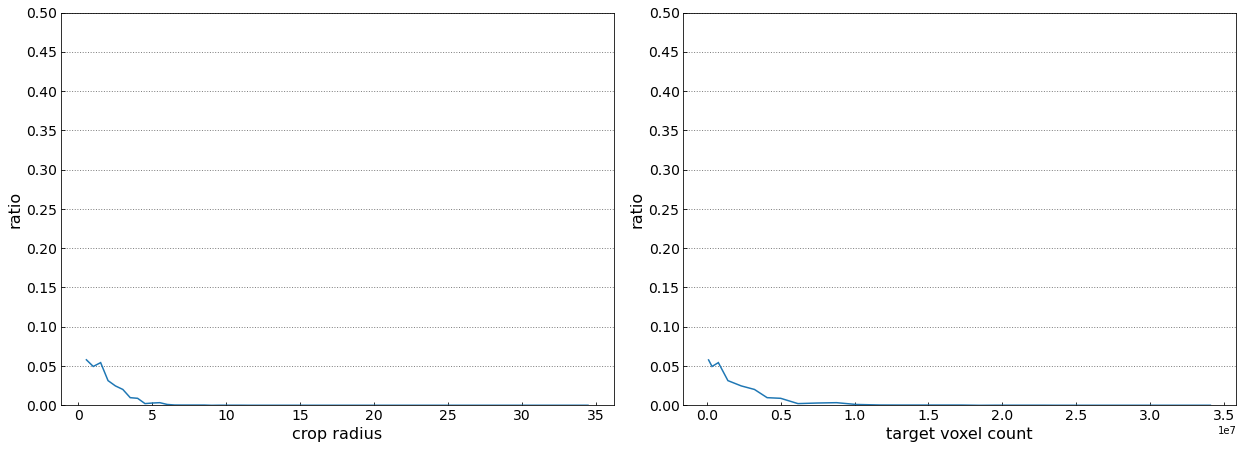

In [15]:
plot_ratio(result_df)